# Описание задачи
## В задачи пректа входит:

- EDA предоставленных данных
- Создание скоринговой модели 
- Эксперименты с моделью (обагащение данных, отбор признаков, различные подходык кодировке признаков и т.д.)
- Подбор гиперпараметров
- Получение предсказанных моделью значений для участие в соревновании на Kaggle


## Описание датасета
Первоначальная версия датасета состоит из 19-ти столбцов, содержащих следующую информацию:

- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car_type**	- флаг автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **foreign_passport** - наличие загранпаспорта
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **score_bki** - скоринговый балл по данным из БКИ
- **region_rating** - рейтинг региона
- **app_date** - дата подачи заявки
- **default** - наличие дефолта (целевая переменная)

# План работы
- Импорт библиотек, определение функций, установка параметров
- Ознакомление с данными, разделение признаков на типы 
- Первичная визуализация, первичный анализ
- Первичная предобработка
- Baseline
- Устранение дисбаланса выборки
- Работа с  выбросами
- Обработка пропусков
- Биннинг числовых признаков, dummy кодирование выделяющихся bin-ов
- Dummy-кодирование категориальных признаков
- Создание новых признаков
- Отбор признаков
- Определение оптимального размера набора данных
- Подбор гиперпараметров
- Получение submission

# Импорт библиотек, определение функций, установка параметров
## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm

import warnings
import os

## Функции используемые в ноутбуке¶

In [2]:
def get_data():
    '''Возвращает обьедеиненный из train и test датасет 
    Проводит первичную обработку: 
     - удаляет идентификатор  client_id 
     - приводит временной ряд app_date к числовому виду       
    '''
    train = pd.read_csv(f'{path}train.csv')
    test = pd.read_csv(f'{path}test.csv')

    train['sample'] = 1  # помечаем где у нас трейн
    test['sample'] = 0   # помечаем где у нас тест
    test['default'] = 0  # в тесте нет значения default -  пока просто заполняем нулями

    data = test.append(train, sort=False).reset_index(drop=True) # объединяем
    
    data.app_date = pd.to_datetime(data.app_date,format='%d%b%Y') # приводим временной ряд
    data.app_date = (data.app_date - data.app_date.min()).dt.days # к числовому виду
    
    data.drop(columns='client_id',inplace=True) # 
    
    return data

def df_describe(df):
    '''
    Вывод простой статистки DataFrame
    '''
    desc = df.describe(include='all',percentiles=[0.5]).T # сохранение отчета от df.describe()
    # получение и сохранение дополнительных статистик/свойств
    desc['type'] = [type(x) for x in df.iloc[0]] # тип данных
    desc['NaN'] = df.isna().sum()                # количество пропусков
    desc.unique = df.nunique()                   # количество уникальных значений
    desc.top = df.mode(axis=0).iloc[0]           # самое распрстроненноё значение
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns] # количество top в признаке
    return desc

def nums_visualisation(df,annotation=False):
    '''
    визуализация распределений количественных признаков: \n
        - гисторгамма распределения \n
        - boxplot распределения
    '''
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))

    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()
    
def num_visualisation(column,df_inp,lg=False):
    '''
    Визулизация распределения количественного ризнака:
        - гистограмма распределения в обучающей выборке при двух значениях целевой переменной
        - boxplot распределения в обучающей выборке при двух значениях целевой переменной
    '''
    df = df_inp.copy()
    
    if lg: df[column] = np.log(df[column]+1)
        
    hue = df.default
    trn = df[df['sample']==1]
    tst = df[df['sample']==0]
    
    row = df[column]
    row1 = trn[column][hue==0]
    row2 = trn[column][hue==1]
    
    fig = plt.figure(figsize=(14,2))
    
    ax1 = fig.add_axes([0, 0.4, 1, 1])
    plt.title('Распределение '+column+' в train в зависимоcти от значения default' )
    row1.plot.kde(alpha = 0.65)
    row2.plot.kde(alpha = 0.65)
    plt.legend(['negative','positive'])
    
    ax2 = fig.add_axes([0, 0, 1, 0.30]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(data = [row1,row2],orient='h',saturation = 0.5)

def cats_visualisation(df,annotation=False):
    '''
    Визуализация распределения категориальных/бинарных переменных
    '''
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(14,2))
    for i,col in enumerate(columns):        
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 1])
        plt.title(col)
        sns.countplot(df[col])
    
    fig = plt.figure(figsize=(14,2))
    hue = data.default
    for i,col in enumerate(columns):
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 1])         
        dist = pd.Series(data.groupby(col).default.value_counts(normalize=True)[:,1])  
        if annotation:
            title = 'Доля полож-ного\n класса default\nв каждой из\nкатегорий\n'+ col
        else:
            title = 'доля default=1'
        dist.plot.bar(title = title)
        
def  predproc_naive(data):
    '''
    Предподготовка для наивной модели
    '''
    feat_to_log = num_cols.drop(['app_date', 'score_bki']) # призеаки со скошенным распределением
    data[feat_to_log] = np.log(data[feat_to_log]+1)        # их логарфмирование
    
    train_ind = data[data['sample']==1].index              # индесксы наблюдений из train в data
    
    scaler = StandardScaler()                                # обучение scaler на наблюдениях из 
    scaler.fit(data.loc[train_ind][num_cols])                # train и нормализация обученным scaler
    data[num_cols] = scaler.transform(data[num_cols].values) # числовых признаков во всем data
    
    coder = LabelEncoder()                      # кодирование категориальных  и бинарных
    column_to_code = cat_cols.append(bin_cols)  # признаков во всем data
    data[column_to_code] = data[column_to_code].apply(lambda x: coder.fit_transform(x))
    
    return data

def numeric_binning(feat,target,max_bin=20):
    '''
    WOE-binning для числовых переменных
    '''
    monotonic = lambda x: all(x.diff()[1:] <= 0) | all(x.diff()[1:] >= 0) # функция проверяющая монотонность
    train_ind = data[data['sample']==1].index                             # индексы строк из train в data
           
    for n in range(max_bin,0,-1):                                  # начиная с n = max_bin пытамся
        try:                                                       # разбить train на n бинов и нсли получилось
            df = pd.DataFrame({"feat": feat[train_ind],            # сохраняем значение признака,  
                               "target": target[train_ind],        # целевую 
                               "bin": pd.qcut(feat[train_ind], n)})# и бин
            binned_feat = df.groupby("bin")                        # группируем по бин
            if monotonic(binned_feat.target.mean()): break         # если разбиение монотонное - выходим из цикла
        except Exception as e:                                     # 
            continue                                               # 
            
    event = binned_feat.target.sum()                                 # расчет по сгруппированному для каждого бина
    nonevent = binned_feat.target.count() - binned_feat.target.sum() # вспомогательных event и nonevent (доли 1 и 0)
    woe = np.log((event/event.sum())/(nonevent/nonevent.sum()))      # WoE и
    iv = (event/event.sum() - nonevent/nonevent.sum()) * woe         # IV
    
    bins_tbl = pd.DataFrame({'woe':woe, 'iv':iv}).reset_index()      # формируем таблицу величин 
    bins_list = bins_tbl.bin.to_list()                               # бин , WoE и IV
    bins_list[0] = pd.Interval(left=-np.inf, right=bins_list[0].right) # крайние бины расширяем до - и + бесконечности
    bins_list[-1] = pd.Interval(left=bins_list[-1].left, right=np.inf) # ВАЖНО: бины расчитываются по train
    bins_tbl.bin = pd.Series(bins_list)                                # впоследствии применяются ко всему df
        
    result = feat.apply(lambda x: bins_tbl[[x in xx for xx in bins_tbl.bin]].woe.iloc[0]) # сосопставляем кажжому наблюдению 
                                                                                          # WoE бина, к которому наблюдение 
    return result, bins_tbl                                                               # принадлежит.


def validation(X,y,model):
    '''
    Валидация модели
    '''
    model = model
    cv_results = cross_validate(model, X, y, scoring=('f1','precision','recall','accuracy'), cv=5,)
    
    result = pd.DataFrame({'mean':pd.Series(cv_results).apply(lambda x:(x.mean())),
             'std':pd.Series(cv_results).apply(lambda x:(x.std()))}).iloc[2:,:]
    return result 

def wiskers(row, wiskers_coef = 1.5):
    '''
    возвращает Lower Inner Fence и Upper Inner Fence метода IQR
    '''
    quart_1 = row.quantile(0.25)
    quart_3 = row.quantile(0.75)
    iqr = quart_3 - quart_1
    l_board = quart_1 - wiskers_coef*iqr
    r_board = quart_3 + wiskers_coef*iqr
    
    return l_board,r_board

def outers_defolt_dist(df):
    '''
    возвращает долю позитивного класса вне Lower Inner Fence и Upper Inner Fence для признаков из df
    '''
    left_outer = []
    right_outer = []
    for feat in df.columns:
        left_b, right_b = wiskers(df[feat])        # получение границ
        left_mask = df[feat] < left_b              # маска индесков слева от левой границы
        right_mask = df[feat] > right_b            # маска индексов справо от правой границы 
    
        left_outer_dist = data.default[left_mask].value_counts(normalize=True).to_list() # получение доли 1 слева
        left_outer_dist = left_outer_dist[1]  if left_outer_dist else np.NaN             # замена [] на NaN
        right_outer_dist = data.default[right_mask].value_counts(normalize=True).to_list() # анлагочино
        right_outer_dist = right_outer_dist[1]  if right_outer_dist else np.NaN            # справа
        
        left_outer.append(left_outer_dist)     # накапливания результатов по
        right_outer.append(right_outer_dist)   # очередному признаку из df.columns
        
    result = pd.DataFrame([left_outer,right_outer],columns = df.columns, index = ['left_outer','right_outer'] )
    
    return result

def class_weight_study():
    '''
    Строит зависимость метрик (f1,precision,recall,accuracy) от веса позитивного класса 
    цеелвой переменной при обучении LogisticRegression.
    Выводит отчет в табличном и графическом виде
    '''
    f1_weight = pd.DataFrame(columns=['test_f1','test_precision','test_recall','test_accuracy'])

    for pos_weight in range(1,14):
        metrics = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:pos_weight}))
        to_append = metrics['mean']             # получениезначений метрик при очерендном значении weight 
        to_append.name = pos_weight             # и их сохрание в pd.Series, замена в Series имени, котрое при  
        f1_weight = f1_weight.append(to_append) # append станет индексом в DataFrame. Добавление Series в DataFrame

    display(f1_weight.T)                        # вывод табличной части отчета

    f1_weight.plot.line(figsize=(15,7),linewidth = 2,   # построение графической части
                        xticks = f1_weight.index,
                        grid=True, 
                        title = "Зависимость метрик от веса позитивного класса ");
    
def model_imputer(model):
    '''
    заполняет пропускив data.education прогнозами переданной модели model
    '''
    imp = model 

    train_ind = data[data['sample']==1].index                             # индексы строк train-а в data
    to_fill_index_train = train_ind[data.loc[train_ind].education.isna()] # индексы с пропусками из train.
    to_fill_index = data.index[data.education.isna()]                     # индексы с пропусками
    
    to_learn_index = train_ind.drop(to_fill_index_train)                  # индексы наблюдение для обучения model

    num_cols.drop(['app_date','score_bki'])                               # логарифмирование скошенных числовых
    data[num_cols.drop(['app_date','score_bki'])] = np.log(data[num_cols.drop(['app_date','score_bki'])]+1)

    scaler = StandardScaler()                                             # обучение scaler на наблюдениях
    scaler.fit(data.loc[train_ind][num_cols].values)                      # из train и нормализация 
    data[num_cols] = scaler.transform(data[num_cols].values)              # всего датасета
    
    data.decline_app_cnt = (                                              # переопределение миноритарных 
        data.decline_app_cnt.apply(lambda x: x if x<4 else 4))            # категорий 
        
    coder = LabelEncoder()                                                # кодирование категориальных признаков 
    column_to_code = cat_cols.append(bin_cols)                            # для обучения model
    data[column_to_code] = data[column_to_code].apply(lambda x: coder.fit_transform(x))
    
    X_imp_train = data[data.columns.drop(['education'])].loc[to_learn_index]
    y_imp_train = data.education.loc[to_learn_index]                      # данные для обучения

    X_to_fill = data[data.columns.drop(['education'])].loc[to_fill_index] # данные для получения предсказания
    
    imp.fit(X_imp_train ,y_imp_train)                                     # обучение model

    data.education[to_fill_index] = imp.predict(X_to_fill)                # заполнение пропусков
    
    return data

## Установка параметров

In [3]:
%pylab inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 70)    # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

# альтернативные пути на kaggle и локальный (НЕ ЗАБЫВАТЬ МЕНЯТЬ!)
path = './Project_5_data/'
# path = '/kaggle/input/sf-scoring/'

RANDOM_SEED = 42

# словарь гиперпараметров для их подбора
solvers_hyperparameters = {
    'newton-cg': {'penalty': ['l2'] , 
                   'tol': logspace(-5,-2,4) ,
                  'C': logspace(-4, 2, 7) , 
                  'class_weight':  [{0:1, 1:x} for x in range(5,6,1)] ,
                  'max_iter': [500] 
                 }, 
    'lbfgs':     {'penalty': ['l2'] , 
                  'tol': logspace(-5,-2,4) ,
                  'C': logspace(-4, 2, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(5,6,1)] ,
                  'max_iter': [500] 
                 }, 
    'liblinear': {'penalty': ['l1', 'l2'] , 
                  'tol': logspace(-5,-2,4) ,
                  'C': logspace(-4, 2, 7) , 
                  'intercept_scaling': [1,3,10,33,100],  
                 'class_weight':  [{0:1, 1:x} for x in range(5,6,1)] 
                 },
    'sag':       {'penalty': ['l2'] , 
                  'tol': logspace(-5,-2,4) ,
                  'C': logspace(-4, 2, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(5,6,1)] ,
                  'max_iter': [500] 
                 }, 
    'saga':      {'penalty': ['l1', 'l2'] , 
                  'tol': logspace(-5,-2,4) ,
                  'C': logspace(-4, 2, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(5,6,1)] 
                 }
}

Populating the interactive namespace from numpy and matplotlib


# Ознакомление с данными, разделение признаков на типы
## Загрузка датасетов, их объединение, ознакомление с данными

In [4]:
train = pd.read_csv(f'{path}train.csv')
test = pd.read_csv(f'{path}test.csv')
sample_submission = pd.read_csv(f'{path}sample_submission.csv')

Для корректной обработки признаков объединяем трейн и тест в один датасет data

In [5]:
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0   # помечаем где у нас тест
test['default'] = 0  # в тесте нет значения default -  пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

train_index = data[data['sample']==1].index # сохраняем data инжексы наблюдений из train 
test_index = data[data['sample']==0].index  # сохраняем data инжексы наблюдений из test 

Проверим наличие дупликатов в данных

In [6]:
data.duplicated().sum()

0

Посмотрим на краткую сводку и простую статистику о наборе данных.

In [7]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Columns: 20 entries, client_id to default
dtypes: float64(1), int64(13), object(6)
memory usage: 16.8+ MB


In [8]:
display(df_describe(data))

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
client_id,110148.0,110148,1,1,55074.5,31797.133063,1.0,55074.5,110148.0,<class 'numpy.int64'>,0
app_date,110148,120,18MAR2014,1491,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
education,109670,5,SCH,57998,NaN,NaN,NaN,NaN,NaN,<class 'str'>,478
sex,110148,2,F,61836,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
age,110148.0,52,31.0,4084,39.24941,11.518063,21.0,37.0,72.0,<class 'numpy.int64'>,0
car,110148,2,N,74290,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_type,110148,2,N,89140,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
decline_app_cnt,110148.0,24,0.0,91471,0.273205,0.799099,0.0,0.0,33.0,<class 'numpy.int64'>,0
good_work,110148.0,2,0.0,91917,0.165514,0.371645,0.0,0.0,1.0,<class 'numpy.int64'>,0
score_bki,110148.0,102618,-1.775263,517,-1.904535,0.499397,-3.624586,-1.920823,0.199773,<class 'numpy.float64'>,0


Как видиим 14 признаков представлены числовым типом данных, 6 строковыми величинами. Из этих 6 "строковых" признаков 4 признака бинарных, один категориальный(5 уникальных значений, одно из них NaN) и один,`app_date`, судя по значению **top** - временной ряд. В числовых признаках 5 признаков разумно отнести к численным (количество уникальных значений от 40 до 110148), 6 признаков являются категориальными(количество уникальных значений от 3 до 24) и 3 признака бинарные.  

Пропуски встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений.  

Сравнивая количество уникальных значений **unique** и частоту  наиболее часто встречающейся категории **freq** можно заметь несбалансированность признаков по категориям. В `foreign_passport` `good_work` `decline_app_cnt` и `default` доля мажоритарной категории составляет около 6/7. Такой дисбаланс, особенно в целевой переменной `*default`(в рней доля положительного класса равна 0.085086) может создать проблемы при обучении модели. В таком случаенам придется предпринимать меры для устранения несбалансированности.

В данных присутвует признак `client_id` - идентификатор клиента, удалим его.

In [9]:
data.drop(columns='client_id',inplace=True)

## Разделение признаков на типы
Разделим признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols` .   
К **бинарным**, очевидно, отнесем признаки с двумя уникальными значениями (созданный нами `sample` не будем рассмптриаать, так же исключим из факторов целевую перемнную `default`).   
**Категориальными** признаками будем считать признаки с количеством уникальных значений от 3 до 30  
Порогом для **количественного признака** будет наличие не менее чем 30 уникальных значений. 

Но для начала **Временной ряд** приведем в числовой вид взяв количество дней прошедших от самой раней даты в ряду.

In [10]:
data.app_date = pd.to_datetime(data.app_date,format='%d%b%Y')
data.app_date = (data.app_date - data.app_date.min()).dt.days

In [11]:
num_threshold = 30 

num_uniq = data.nunique()
# time_col = pd.Index(['app_date'])
bin_cols = data.columns[num_uniq==2].drop(['sample','default'])
cat_cols = data.columns[(num_uniq>2) & (num_uniq<num_threshold)]
num_cols = data.columns[num_uniq>=num_threshold] 

# Первичная визуализация, первичный анализ
Осуществим первичную визуализацию **числовых признаков**

Всего признаков этого типа 5. К ним относятся: app_date, age, score_bki, bki_request_cnt, income


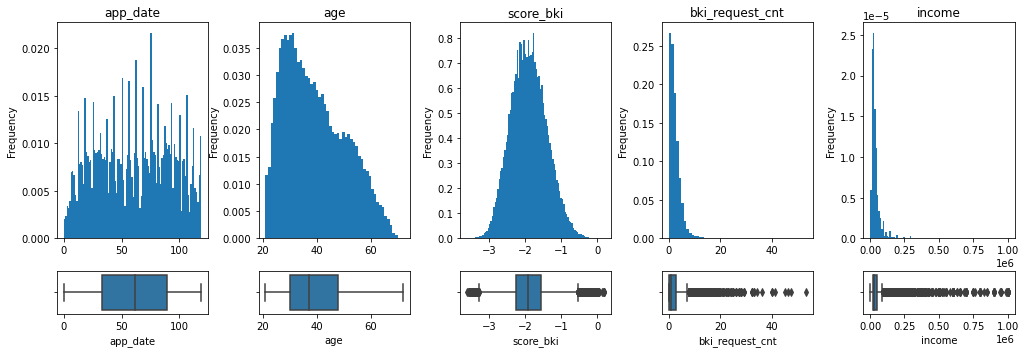

In [12]:
nums_visualisation(data[num_cols],annotation=True)

Кроме `app_date` и `score_bki`  числовые признаки имеют сильно скошенное вправо распределение. Такая ассиметрия будет мешать модели. Применим логарифмирование к скошенным признакам: 

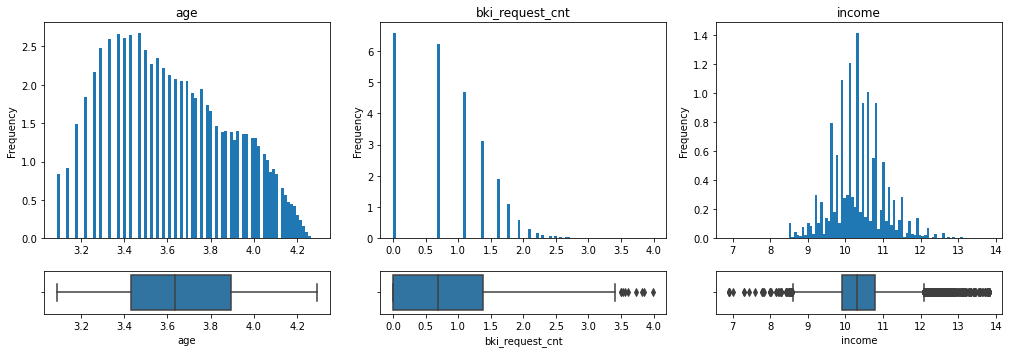

In [13]:
nums_visualisation(np.log(train[num_cols.drop(['app_date','score_bki'])]+1))

Ситуация улучшилась: логарифмированные `age` и `income` рапсределены похоже на нормально, а в `bki_request_cnt` скошенность, судя по boxplot существенно уменьшилась. Значит при предобработке применим логарифирование.  
Так же во всех признаках, кроме `age`есть длинные "хвосты" в распределениях - возможные выбросы, аномалии. Их наличие может неблагоприятно сказаться на точности модели. Позже проверим наличие этой проблемы и примем меры по её решению.


Теперь посмотрим на **категориальные признкаи**

Признаков этого типа 7. К ним относятся: education, decline_app_cnt, region_rating, home_address, work_address, sna, first_time


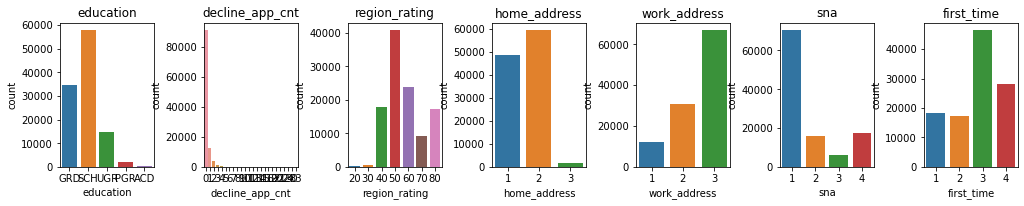

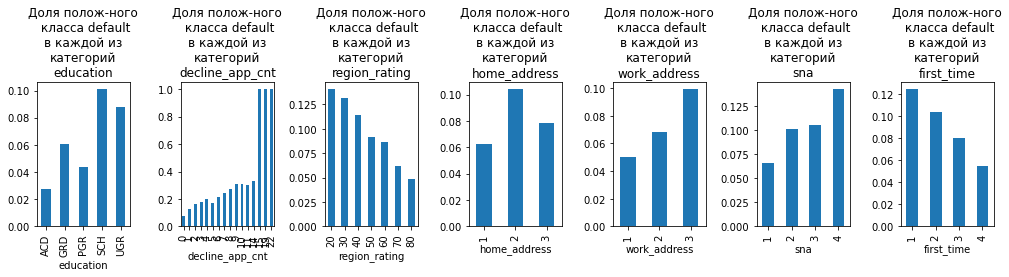

In [14]:
cats_visualisation(data[cat_cols],annotation=True)

Как видим распределение по категориям в признаках имеет несбалансированый характер(крайне малочисленные категории пристутвуют напрмер в `education`, `decline_app_cnt`, `region_rating`). На последующих этапах работы возможно будет иметь смысл обьеденить миноритарные категории в одну. Классы, что имеют очень малую долю в распределении необходимо проверить -  не являются ли они выбросами.  
Сравнение доли положительного класса в зависимости от категории во многоих признаках (например - `education`, `region_rating`, но осбенно `decline_app_cnt`) указывают на их(признаков) потенциальную полезность.

Рассмотрим **бинарные признаки**

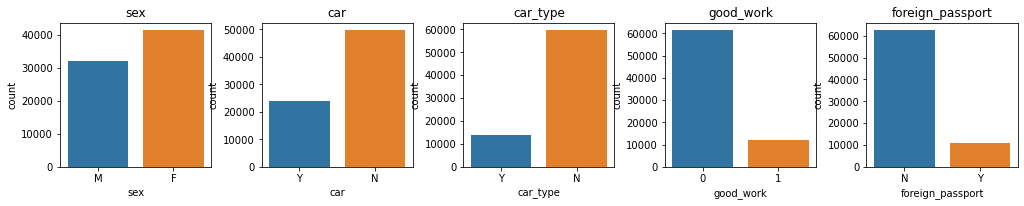

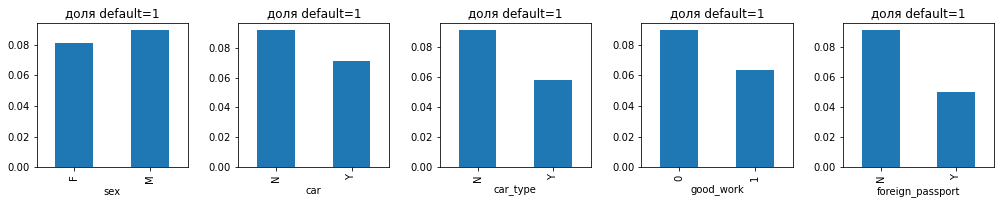

In [15]:
cats_visualisation(train[bin_cols]) 

Бинарные факторы в большинстве тоже несбалансированы, но это не так интересно, как доля положительного клааса в каждой категории. Если признак `sex` кажетcя малоинформативным, то `foreign_passport` вероятно окажеться полезен.  

Более глубокий анализ, обработку выбросов, заполнение пропусков, возможное обьединение категорий, биннинг числовых признаков проведем на следующих этапах, а сейчас подготовим данные для обучения наивной модели, которая будет служить нам  **Baseline**.

# Первичная предобработка

 **Пропуски** встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений. Поэтому для построения  **Baseline**, мы просто удалим эти 0,5% наблюдений.  
**Числовые признаки** co скошенным распределением логарфмируем (т.е. все кроме `score_bki` и `app_date`), затем все признаки нормализуем  
**Бинарные признаки** и **Категориальные признаки** мы кодируем самым простым методом, используя реализацию `sklearn.preprocessing.LabelEncoder`  

In [16]:
data.dropna(subset=['education'],inplace=True)
data = predproc_naive(data)

# Baseline
Обучим на подготовленных данных модель `LogisticRegression()` с параметрами по умолчанию и получим значения метрик. Для оценки модели по условиям задачи гланой основной метрикой будет **F1**, вспомогательными возьмём - , **Precision**, **Recall** и **Accuracy**.
Для понимания стабильности результата посмотирим и стндартное отклонение метрик.

Мы будем рассматривать эту модель как первую итерацию, первое приближение которое нужно последовательно улучшать.

In [17]:
X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = data[data['sample']==1].default

In [18]:
metrics_naive = validation(X_train, y_train, LogisticRegression())
metrics_naive

,mean,std
test_f1,0.046902,0.005365
test_precision,0.452066,0.072996
test_recall,0.024741,0.002783
test_accuracy,0.872217,0.001076


Целевая метрика **F1** неприлично мала. При взгляде на пару вспомогательных **precision** и **recall** становится понятно что проблема в том что модель позитивный класс почти игнорирует.    
Из того, что модель отнесла к позитивному классу почти половина действительно к нему относится (что, учитывая что доля класса в выборке приблизительно **0,085**, оказывается гораздо лучше случайного угадывания).   
Но вот из реального положительного класса модель таковым посчитала лишь **0,03**! Т.е. верно классифицированным позитвным классом оказалось **0.03 * 0.085** = **0,0025** часть выборки. Приблизительно столько же (**precision** = **0.45**) отнесено к позитивному классу ошибочно. Итого по мнению модели к позитивному классу относится около **0.005** выбоки при реальной доле **0.085**...     
Причины такого фиаско могут быть следующие -  дисбаланс классов, плохо подготовленные данные,  ненастроенная модель. Попробуем последовательно решить эти проблемы. Начнем с несбалансированности выборки.

# Устранение дисбаланса выборки

полность сбаоансированной выборка станет, если увеличить количество позитивного класса в `(1-0.085)/0.085` раз. Или в

In [19]:
print (round((1-0.085)/0.085), 'раз')

11 раз


Посмотрим как ведуь себя метрики при разных весах миноритарного(позитивного) класса:

,1,2,3,4,5,6,7,8,9,10,11,12,13
test_f1,0.046902,0.212577,0.307189,0.338816,0.343867,0.345054,0.337464,0.327900,0.319572,0.311321,0.304023,0.296900,0.291250
test_precision,0.452066,0.393001,0.327969,0.286710,0.258206,0.241015,0.224886,0.211700,0.201492,0.192686,0.185590,0.179315,0.174413
test_recall,0.024741,0.145765,0.288960,0.414160,0.514728,0.607262,0.675806,0.726893,0.771983,0.810111,0.840206,0.862483,0.882297
test_accuracy,0.872217,0.862815,0.834458,0.794671,0.750490,0.707124,0.662888,0.621442,0.582376,0.544672,0.511294,0.481032,0.454458


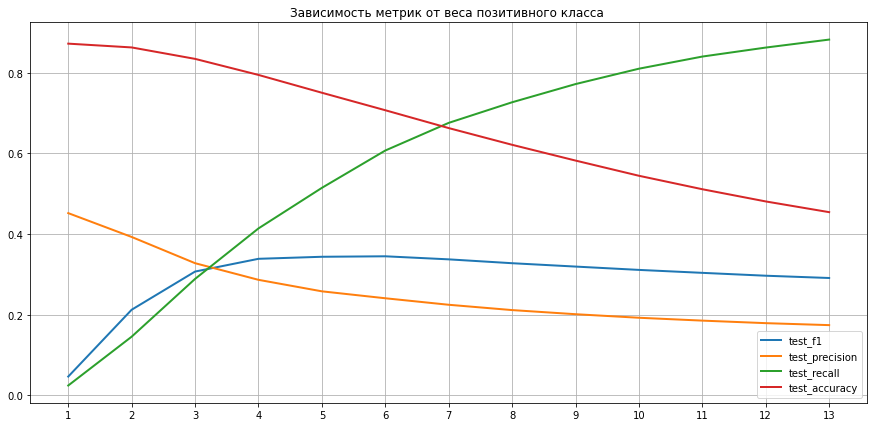

In [20]:
class_weight_study()

Как видим при росте веса позитивного класса:   
- монотонно растет **recal**,  
- монотонно убывают **precision** и **accuracy**  
- сначала довольно быстро возрастает основная метрика **f1** , затем очень медленно снижается

Я такое поведение вижу как сдвиг с ростом веса позитивного класса  разделяющей гиперплоскости от центра класса позитвного в сторону центра класса негативного.   
При этом:
- все больше позитивного класса попадает в 'позитвную' область и классификатор правильно его классифицирует как позитивный
- но вместе с тем тудаже, в 'позитвную' область, попадает все больше и негативного класса, вследствие чего классификатор ошибочно относит его к позитвному.

Исходя из поведения метрик и нашей цели можем выбрать оптимальный для нас вес. Для участия в соревновании, где метрикой является **F1**  возьмем максимизирующий её вес **5**. Если бы нам было важно как можно полно верно классифицировать неплательщиков, вес стоило взять побольше(помня при этом что с ростом веса мы теряем верно классифицированных хороших клиентов)

In [21]:
metrics_class_weight = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_class_weight

,mean,std
test_f1,0.343867,0.009006
test_precision,0.258206,0.006348
test_recall,0.514728,0.017412
test_accuracy,0.750490,0.003812


Посмотрим на изменеия метрик:

In [22]:
metrics_class_weight/metrics_naive

,mean,std
test_f1,7.331671,1.678880
test_precision,0.571170,0.086962
test_recall,20.804943,6.255771
test_accuracy,0.860439,3.543230


Радикальный рост в **F1** и **Recall** (в 7 и 20 раз соответственно) и ощутимые потери в **precision** и **accuracy** (на 40 и 15 %). НЕплохой результат.  
Но останавливаться не будем, перейдем к подготовке данных и начнем с выбросов.

# Работа с  выбросами

Поскольку в дальнейшем будет осущетсвлен биннинг числовых переменных, то проблему выбросов в них отчасти можно считать решенной. Однако все же применим ***IQR***, найдем наблюдения вне границ и посмотрим на распределение целевой переменной в этих "хвостах". Если обнаружим аномальую, противоречащую логики картину, то это будет указывать на выбросы/ошибочные наблюдения, от которых лучше все таки избавится.   
Применим собственную `outers_defolt_dist`, которая возвращает долю положительного класса за левой (Q1-1.5xIQR) и правой (Q3+1.5xIQR) границей. 

In [23]:
outers_defolt_dist(data[num_cols]) 

,app_date,age,score_bki,bki_request_cnt,income
left_outer,NaN,NaN,0.024691,NaN,0.070034
right_outer,NaN,NaN,0.239631,0.266667,0.066860


При этом в общем по выборке доля положительного класса соствляет:

In [24]:
round(data.default.value_counts(normalize=True)[1],6)

0.085137

Сравним ***defolt_dist*** на всей выборке и в "хвостах" и попытаемся сделать какие то выводы.

- В **app_date** выбросов нет. Ок
- И в **age** выбросов нет. Хорошо бы везде так.    
- В **score_bki** формально выбросы есть и слева и справа. При этом ***defolt_dist*** ведет себя абсолютно логично - при экстремально малых значениях  скорингового балла **score_bki** экстремально низкая доля "дефолтных" клиентов, при экстремально высоких знвчениях - существенно повышенная.
- В **bki_request_cnt** слевыа выбросов нет, справа присутсвуют. Поведение укладывается в рамки здравого смысла - при экстремально большом количестве запросов значительно повышается доля "дефолтных" клиент.ов (т.е. ненадежным клиентам приходится много раз запрашивать в разных местах кредиты, и возможно они их уже понабрали, что делает их еще менее интересными заемщиками)
- В **income** формально выбросы есть и слева и справа. Пониженные значения ***defolt_dist*** в правом хвосте не вызывают удивления - обеспеченные клиенты более кредитоспособны. А вот немного, но ниже среднего ***defolt_dist*** в левом хвосте немного озадачивает. Посмотрим на распределение поближе.

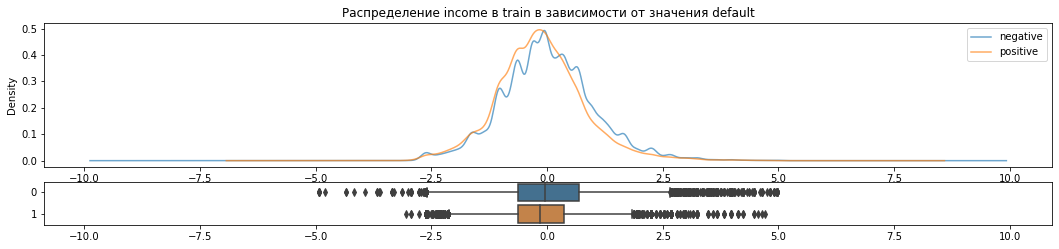

In [25]:
num_visualisation('income',data)

Наблюдается любопытная картина - не только макисмальные, но и минимальные доходы у недефолтных клиентов (это особенно хорошо видно на boxplot-ах). Обьяснение такому поведени распределения можно найти - напрмер официальный минимальный **income** у тех, кто не полность показывает свой доход.  Или, что выглядит более логично, клиентам с минимальными доходами просто не дают кредитов. А раз нет кредитов то  и дефолтов по ним тоже нет.   
Попробуем понять, как обстоят дела в действительости. Для это посмотим на распределения признаков, косвенно говорящих о благосостоянии клиента на всей выборке и в левом хвосте. Признаками будут `car`, `car_type`,`good_work`, `foreign_passport`. Будем использовать собственную `wiskers`, возвращающую *Lower Inner Fence* и *Upper Inner Fence*. 

In [26]:
to_study = ['car', 'car_type','good_work', 'foreign_passport']
left_iqr_bound = wiskers(data.income)[0]
left_outer_index = data.index[data.income < left_iqr_bound]
total_dist = data[to_study].apply(lambda x: x.value_counts(normalize=True)).loc[1]
left_outer_dist = data.loc[left_outer_index][to_study].apply(lambda x: x.value_counts(normalize=True)).loc[1]

pd.DataFrame({'total':total_dist, 'left_outer':left_outer_dist}).T

,car,car_type,good_work,foreign_passport
total,0.325139,0.190854,0.165615,0.149029
left_outer,0.118255,0.059701,0.146958,0.133180


Похоже в левом хвосте и в правду находятся люди с низкими доходами и наверное без кредитов вообще. Зато и дефолтов у них тоже нет.

Обратимся теперь к категориальным переменнным. Для поиска выбросов в воспользуемся графиками и здравым смыслом:

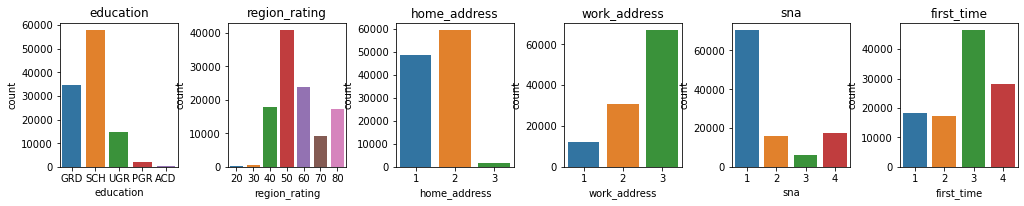

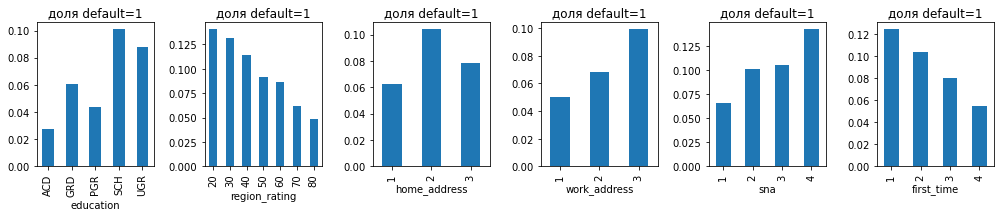

In [27]:
data = get_data()
cats_visualisation(data[cat_cols.drop('decline_app_cnt')])

**education** -  в распределении присутствуют пара миноритарных категорий ***ACD*** и ***PGR*** (ученая степень и аспирант). У этих категорий минимальная доля дефолтов. Их малочисленность и достаточная финасовая дисциплина абсолютно логичны. Нет повода считать эти категории выбросом.  
**region_rating** -  в распределении две миноритарных категории ***20*** и ***30*** (это два минимальных значения рейтингв). И вполне в соответствии с рейтингом высока(максимальна) доля дефолтов. Нет противоречия здравому смыслу и повода считать эти две категории выбросом. Остается порадоваться их малому колчеству.  
**home_address**, **work_address**, **sna** нам неизвестно значение категорий, потому мы не можем судить о логичности распределения доли позитивгой класса по категориям. оставляем как есть. 
**first_time** - распределение приблизительно раномерное.

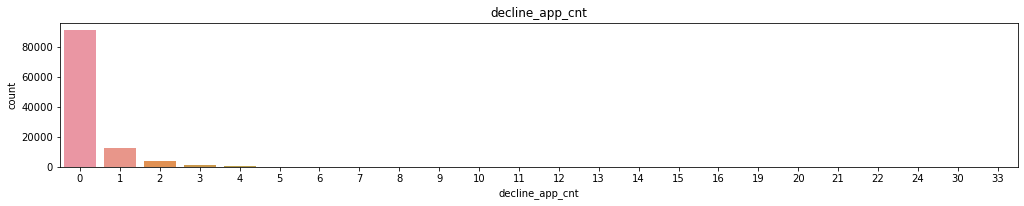

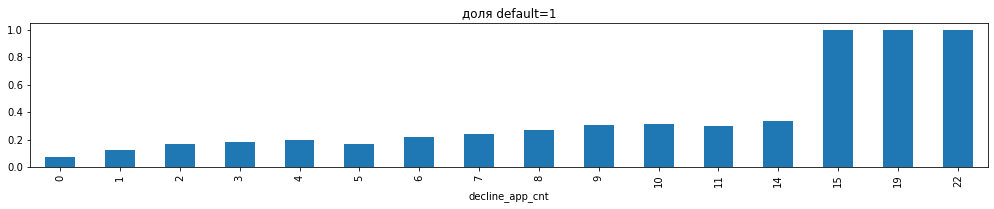

In [28]:
cats_visualisation(data[['decline_app_cnt']])

**decline_app_cnt** - все, кроме первой пары категорий можно смело относить к миноритарным. Большое количество крайне малочисленных категорий вынудит провести их обьедениение. Примем в этом признаке 5 категорий - **0**, **1**, **2**, **3** и **>=4**

В результате проведенног анализа выбросы не обнаружены, т.е. датасет не изменился, соответсвенно и метррики не изменились. Идем дальше

## Обработка пропусков
В наивном **Baseline** мы просто удалили пропуски в единственном не полностью заполненом признаке `education`. Испытаем более интелектуальный подход. Попробуем обучить классификатор на наблюдениях без пропусков и затем заполнить пропуски его предсказаниями.
Для эксперимента возьмём три классификатора `RandomForestClassifier`, `GradientBoostingClassifier` и `KNeighborsClassifier`. Выберем лучший по изменению метрик. Будем использовать собсвенную функцию `model_imputer`, которая возвращает **data** с пропусками заполненными переданными функции классификатором

Обучим модели на обновленных данных и посмотрим на метрики.

In [29]:
%%time
data = get_data()
data = model_imputer(RandomForestClassifier())

X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = data[data['sample']==1].default

metrics_rfc_fill = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_rfc_fill

Wall time: 25.8 s


,mean,std
test_f1,0.345342,0.008384
test_precision,0.259203,0.005959
test_recall,0.517388,0.016581
test_accuracy,0.750932,0.003921


In [30]:
%%time
data = get_data()
data = model_imputer(GradientBoostingClassifier())

X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = data[data['sample']==1].default

metrics_gbc_fill = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_gbc_fill

Wall time: 1min 33s


,mean,std
test_f1,0.345355,0.008425
test_precision,0.259217,0.005997
test_recall,0.517388,0.016581
test_accuracy,0.750945,0.003929


In [31]:
%%time
data = get_data()
data = model_imputer(KNeighborsClassifier())

X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = data[data['sample']==1].default

metrics_knc_fill = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_knc_fill


Wall time: 3.95 s


,mean,std
test_f1,0.345483,0.008643
test_precision,0.259336,0.006108
test_recall,0.517495,0.017099
test_accuracy,0.751040,0.003940


Лучший результат у `KNeighborsClassifier()`, использовать будем его.

Посмотим насколько изменились метрики **metrics_knc_fill** по сравнению с **metrics_class_weight** опимизированного по весам классов `LogisticRegression`

In [32]:
metrics_knc_fill - metrics_class_weight

,mean,std
test_f1,0.001616,-0.000363
test_precision,0.001129,-0.000240
test_recall,0.002767,-0.000313
test_accuracy,0.000550,0.000128


Изменения незначительные (порядка 0.5 % от величинв основной метрики), что и не удивительно. Ведь мы заполнли пропуcки всего  в 0,5% наблюдений. Но заполнили, видимо неплохо, ведь эффект неотрицательный.  
В качетсве еще одного экпереимента заполним пропуски модой и посмотим насколько этот распространенный метод хуже.

In [33]:
to_fill_index = train_index[data.loc[train_index].education.isna()] # индексы с пропусками из train.

data.education[to_fill_index] = data.education.mode()[0]

X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = train.default

metrics_mode_fill = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_mode_fill

,mean,std
test_f1,0.345483,0.008643
test_precision,0.259336,0.006108
test_recall,0.517495,0.017099
test_accuracy,0.751040,0.003940


In [34]:
metrics_knc_fill - metrics_mode_fill

,mean,std
test_f1,0.0,0.0
test_precision,0.0,0.0
test_recall,0.0,0.0
test_accuracy,0.0,0.0


Сюрприз! Похоже метод ближайших соседей заполнил пропуски так же или почти так же как и мода. Учитывая, что мажоритарного класса SCH в признаке больше половины (57998 из 109670), то с большой вероятность у пропуска в ближайших соседях будет доминировать именно мажоритарный класс (если предположить более-менее равномерность распределения SCH и пропусков в признаковом прстранстве).

## Биннинг числовых признаков, dummy кодирование отобранных по IV бинов

В каждом из числовых признаков `age`, `score_bki`, `bki_request_cnt`, `income` проведем монотонный WoE бининг. Для этого используем сосбтвенную реализацию `numeric_binning`, которая возвращает обработанный признак и таблицу бинов с соотвтетвующими им значениями **WoE** и **IV**. 

После проведения бининга обучим модель и сравним полученные метрики с ранее достигнутыми результатами.   
Затем проэкспериментируем с выделением в отдельные dummy-признаки бинов, в которых IV превысит пороговое значение 0.02. 

In [35]:
data = get_data()
data = model_imputer(KNeighborsClassifier())

Проведем биннинг

In [36]:
%%time
for feat in num_cols:
    data[feat] = numeric_binning(data[feat],data.default)[0]


X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = train.default

metrics_num_binning = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_num_binning

Wall time: 9min 39s


,mean,std
test_f1,0.346758,0.009471
test_precision,0.259183,0.006625
test_recall,0.523896,0.018759
test_accuracy,0.749387,0.004164


In [37]:
metrics_num_binning - metrics_knc_fill

,mean,std
test_f1,0.001276,0.000827
test_precision,-0.000153,0.000517
test_recall,0.006402,0.001660
test_accuracy,-0.001653,0.000224


Изменения по сравнению с метриками на предидущем этапе **metrics_knc_fill** незначительные , но все же рост. Ктому же бининг поавышает робастность, так что - сочтем процедуру полезной.  

Теперь проведем dummy-кодирование бинов со значением IV превышающим 0.02

In [38]:
%%time
for feat in num_cols:
    
    bins_tbl = numeric_binning(data[feat],data.default)[1]
    bins = bins_tbl.bin
    to_dummy_mask = bins_tbl.iv > 0.02

    bins_list = bins.to_list()
    bins_list[0] = pd.Interval(left=-np.inf, right=bins.to_list()[0].right)
    bins_list[-1] = pd.Interval(left=bins.to_list()[-1].left, right=np.inf)
    
    to_dummy = pd.Series(bins_list)[to_dummy_mask]
    for i,bin_to_dummy in enumerate(to_dummy):
        data[feat + '_'+str(i)] = data[feat].apply(lambda x: x in bin_to_dummy).astype(int)
         

Wall time: 8min 55s


In [39]:
X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = train.default

metrics_num_bin_dum = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:6}))
metrics_num_bin_dum

,mean,std
test_f1,0.344275,0.007597
test_precision,0.239878,0.005504
test_recall,0.609685,0.014899
test_accuracy,0.705050,0.005135


In [40]:
metrics_num_bin_dum - metrics_num_binning

,mean,std
test_f1,-0.002484,-0.001874
test_precision,-0.019305,-0.001120
test_recall,0.085789,-0.003860
test_accuracy,-0.044337,0.000971


Первый неудачный эксперимент: никакого улучшения, даже небольшой падение метрик. Хорошо, что бининг и dummy-кодирование при превышении IV порога проведены раздельно и есть возможность разделить эффекты от них.

## Dummy-кодирование категориальных признаков

In [41]:
%%time
data = get_data()
data = model_imputer(RandomForestClassifier())

for feat in num_cols:
    data[feat] = numeric_binning(data[feat],data.default)[0]

Wall time: 8min 40s


In [42]:
data = pd.get_dummies(data,columns=cat_cols)

In [43]:
X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = train.default

metrics_dum = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_dum

,mean,std
test_f1,0.353507,0.007812
test_precision,0.263040,0.006190
test_recall,0.539049,0.015137
test_accuracy,0.749617,0.005164


In [44]:
metrics_dum - metrics_num_binning

,mean,std
test_f1,0.006748,-0.001659
test_precision,0.003858,-0.000434
test_recall,0.015153,-0.003622
test_accuracy,0.000230,0.001000


Прирост основной метрики 2% от её величины. Неплохо. 

## Создание новых признаков
Cоздадим несколько признаков основываясь на предположениях о возможных зависимостях.  

In [45]:
data = get_data()

In [46]:
# кумулятивная 'крутость' клиента по машине, иномарке, загранпаспорту и хорошей работе
coolness_car = np.array([2 if x=='Y' else 1  for x in data.car])
coolness_import_car = np.array([2 if x=='Y' else 1  for x in data.car_type])
coolness_passport =  np.array([2 if x=='Y' else 1  for x in data.foreign_passport])
coolness_work = np.array([2 if x=='Y' else 1  for x in data.good_work])
data['collness'] = coolness_car*coolness_import_car*coolness_passport*coolness_work
# разница 'расширенная кумулятивная крутость' клиента по машине, иномарке, загранпаспорту, хорошей работе и work_address и
# 'кумулятивная крутость' клиента по машине, иномарке, загранпаспорту и хорошей работе
# признак обнаружен при созерцании пары графиков 'кумулятивная крутость' и 'крутость' :). 
# интересен монотоной зависимостью доли default
coolness_car = np.array([2 if x=='Y' else 1  for x in data.car])
coolness_import_car = np.array([2 if x=='Y' else 1  for x in data.car_type])
coolness_passport =  np.array([2 if x=='Y' else 1  for x in data.foreign_passport])
coolness_work = np.array([2 if x=='Y' else 1  for x in data.good_work])
data['collness_diff'] =  (coolness_car*coolness_import_car*coolness_passport*coolness_work*(4-data.work_address) - 
            coolness_car*coolness_import_car*coolness_passport*coolness_work)
# 'кумулитивная хорошесть' адрессов
monoton_home_address = data.home_address.map({1:3 ,2:1 ,3:2 })
data['collness_address'] = monoton_home_address*(4-data.work_address)

Появились новые признаки. Надо переопределить `cat_cols`

In [47]:
num_uniq = data.nunique()
cat_cols = data.columns[(num_uniq>2) & (num_uniq<num_threshold)]

In [48]:
%%time
data = model_imputer(RandomForestClassifier())

for feat in num_cols:
    data[feat] = numeric_binning(data[feat],data.default)[0]

data = pd.get_dummies(data,columns=cat_cols)

X_train = data[data['sample']==1].drop(columns=['sample','default'])
y_train = train.default

metrics_new_feat = validation(X_train, y_train, LogisticRegression(class_weight={0:1,1:5}))
metrics_new_feat

Wall time: 8min 37s


,mean,std
test_f1,0.354401,0.007125
test_precision,0.263756,0.005553
test_recall,0.540223,0.015247
test_accuracy,0.750064,0.004934


In [49]:
metrics_new_feat - metrics_dum

,mean,std
test_f1,0.000894,-0.000687
test_precision,0.000715,-0.000637
test_recall,0.001174,0.000110
test_accuracy,0.000447,-0.000231


Новые признаки улучшили метрику. Не зря старались. Оставляем.
## Отбор признаков

Благодаря созданию новых признаков и их дальнейшей обработке в наборе уже несколько десятков признаков. Наверное уже имеет смысл попробовать отбросить те из них, что неполезны для модели - это вероятно улучшит качество и точно ускорит обучение.  

Прибегнем к отбору при помощи ***Lasso*** . Обучим эту модель на обогащенном по признакам наборе данных.

In [50]:
from sklearn.linear_model import Lasso

In [51]:
selector = Lasso(alpha=0.0001)
selector.fit(X_train,y_train)

Lasso(alpha=0.0001)

Теперь получим список упорядоченных по полезности с точки selector-модели признаков. 

In [52]:
sorted_by_Lasso = (abs(pd.Series(selector.coef_,index = X_train.columns)) # Seris модулей коэффициентов
                   .sort_values()                                         # отсортированный 
                   .index)                                                # его индексы - названия признаков

После чего станем удалять их по одному, начиная с самого неполезного. И при этом будем следить за изменением метрики и остановимся на том количестве удаляемых признаков при котором изменение метрики будет наиболее выгодным.

In [53]:
model = LogisticRegression(random_state=RANDOM_SEED,class_weight={0:1,1:5})
metrics_changes = pd.Series()

for loc in tqdm(range(0,len(sorted_by_Lasso),1)):
    to_drop = sorted_by_Lasso[:loc] 
    X_tmp = X_train.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y_train,model)
    metrics_changes.loc[loc] = metrics_tmp.loc['test_f1']['mean']

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [02:48<00:00,  2.95s/it]


Посмотрим сколько пизнаков из **sorted_by_Lasso** наиболее выгодно отбросить и какова метрика на наборе с отобранными таким образом признаками

In [54]:
print('Оптимально отбросить {} признаков, метрика при этом будет равна {}'.
      format(metrics_changes.idxmax(),  metrics_changes.max()))

Оптимально отбросить 29 признаков, метрика при этом будет равна 0.3555725991353021


Мы неплохо сократим обьем данных! И немного, но опять увеличим метрику. Кругом профит.

In [55]:
to_drop = sorted_by_Lasso[:metrics_changes.idxmax()]
X_train_select = X_train.drop(columns=to_drop)

## Определение оптимального размера набора данных
В дальнейшем при отборе призгаков, при подборе гиперпараметров нам предстоит многократное обучение модели на обучающей выборке. Для того чтобы оптимизировать по времени обучения процесс, проверим зависимость метрики от размера выборки, возможно что начиная с некоторого момента рост размера обучающей выборки перестает ощутимо влиять на качество модели и мы сможет произвести эксперименты используя сокращенный/оптимизированный набор данных.

Получим при различных значениях взятой для обучения доли исходных данных значения метрики на тестовой выборке.

In [56]:
%%time
model = LogisticRegression(class_weight={0:1,1:5})
cv = StratifiedKFold(n_splits=20,shuffle=True,random_state=RANDOM_SEED)

_, _, test_scores = learning_curve(
       model, X_train, y_train, train_sizes=np.linspace(.1, 1.0, 19), cv=cv, scoring = 'f1')

Wall time: 6min 31s


Визуализируем полученный результат

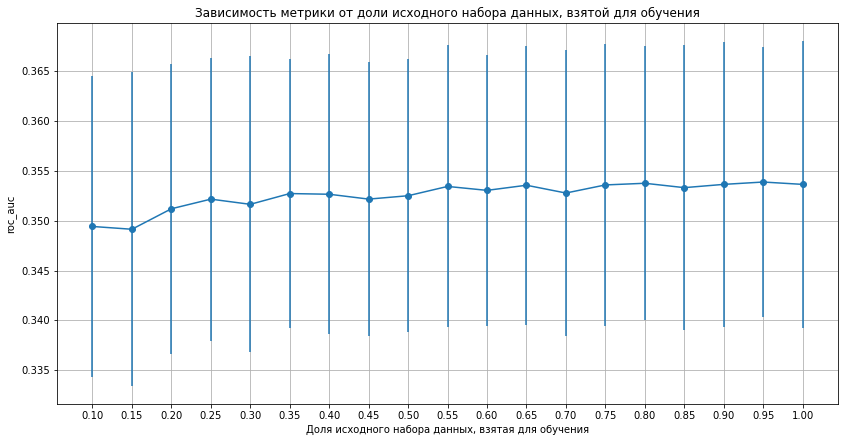

In [57]:
train_prop = np.linspace(.1, 1.0, 19)

test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(14,7))
plt.grid(True)
plt.xticks(train_prop)
plt.errorbar(train_prop, test_scores_mean , yerr = test_scores_std, fmt='o-')

plt.title('Зависимость метрики от доли исходного набора данных, взятой для обучения')
plt.ylabel('roc_auc')
plt.xlabel("Доля исходного набора данных, взятая для обучения");

Как видим где то после 0.5-0.6 выборки метрика стабилизируется.  Примем в качестве оптимального с точки зрения затрат времени размер данных в 0.5 от исходного. В этом решении есть изрядняа доля волюнтаризма, но время поджимает, приходится нго экономить.

In [58]:
%%time
X_train_opt, _, y_train_opt, _ = train_test_split(
    X_train, y_train, train_size=0.5, stratify=y_train, random_state=RANDOM_SEED)            

validation(X_train_opt, y_train_opt, LogisticRegression(class_weight={0:1,1:5}))

Wall time: 3.82 s


,mean,std
test_f1,0.347499,0.008697
test_precision,0.257986,0.006555
test_recall,0.532226,0.014588
test_accuracy,0.746172,0.004388


Метрики просели, но это плата за сильно сокращенное время обучения. Окончательную модель обучим на полном датасете

## Подбор гиперпараметров

Для подбора гиперпараметров будем использовать оптимальный по признакам и количесву наболюдений данных. Используем для поиска парметров, близких к оптимальным реализацию ***sklearn.model_selection.RandomizedSearchCV***. Этот подход позволяет обойтись меньшимим ресурсами, по сравнению с, например, ***GridSearchCV***.

In [59]:
X_train_select_opt, _, y_train_opt, _ = train_test_split(
    X_train_select, y_train, train_size=0.5, stratify=y_train, random_state=RANDOM_SEED)  

In [60]:
%%time
n_iter = 50
search = pd.Series()

for solver in tqdm(solvers_hyperparameters):
    hyperparameters = solvers_hyperparameters[solver]
    model = LogisticRegression(solver=solver, random_state=RANDOM_SEED)
    clf = RandomizedSearchCV(model, hyperparameters, n_iter=n_iter, scoring='f1', cv=5, random_state=RANDOM_SEED)
    search[solver] = clf.fit(X_train_select_opt, y_train_opt)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:48<00:00, 153.69s/it]

Wall time: 12min 48s


Получим оптимальные из перебранных solver и прочие параметры модели. Так же посмотрим на метрику выбранной модели.

In [61]:
fin_solver = search.apply(lambda x: x.best_score_).idxmax()
fin_params = search[fin_solver].best_params_
fin_solver, search[fin_solver].best_score_, fin_params

('sag',
 0.3531375060213729,
 {'tol': 0.001,
  'penalty': 'l2',
  'max_iter': 500,
  'class_weight': {0: 1, 1: 5},
  'C': 1.0})

Метрика улучшилась. Хорошо.
Определим окончательную модель.

In [62]:
fin_model = search[fin_solver].best_estimator_

Проведем валидацию этой модели и убедимся в возросшем её качестве на полном датасете:

In [63]:
validation(X_train_select, y_train, fin_model)

,mean,std
test_f1,0.355555,0.006818
test_precision,0.265188,0.005654
test_recall,0.539583,0.013605
test_accuracy,0.751595,0.005090


Все Ок. Переходим к завершающему этапу.

## Получение submission

Обучим модель

In [65]:
fin_model.fit(X_train_select,y_train)

LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=500, random_state=42,
                   solver='sag', tol=0.001)

In [66]:
X_test_select = data[data['sample'] == 0].drop(columns=to_drop.append(pd.Index(['sample', 'default'])))

In [67]:
pred = fin_model.predict(X_test_select)

Сформируем и отправим submission:

In [68]:
submission = pd.DataFrame(dict(client_id = test.client_id,default = pred))
submission.to_csv('submission_1.csv', index=False)